In [1]:
import cv2 
import matplotlib.pyplot as plt 
import albumentations as alb
import numpy as np 
import tensorflow as tf 
import json
import os
import math
import time

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Prepare Coordinates


In [2]:
def load_coordinate(label_path) :
  with open(label_path, 'rb') as file :
    label = json.load(file)
    
  return [
    int(math.ceil(label["shapes"][0]['points'][0][0])),
    int(math.ceil(label["shapes"][0]['points'][0][1])),
    int(math.ceil(label["shapes"][0]['points'][1][0])),
    int(math.ceil(label["shapes"][0]['points'][1][1])),
  ]

Crop face on image


In [3]:
def preprocess(folder_in, folder_out, coordinates, label) :
  curentImg = cv2.imread(folder_in)
  curentImgRGB = cv2.cvtColor(curentImg, cv2.COLOR_BGR2RGB)    
  
  cv2.imwrite(
    os.path.join('Cropped_Face_Images', folder_out, 'Quoc', label.split('.')[0] + '.jpg'), 
    cv2.resize(
      curentImgRGB[coordinates[1] : coordinates[3], coordinates[0] : coordinates[2]],
      (120,120)
    )
  )
  
  print("Processing : ", label.split('.')[0] + '.jpg')

In [ ]:
for folder in ['Data_Train', 'Data_Test', 'Data_Validation'] :
  for label_file in os.listdir(os.path.join(folder, 'Quoc_Label')) :
    coordinates = load_coordinate(os.path.join(folder, 'Quoc_Label', label_file)) 
    folder_in = os.path.join(folder, 'Quoc', label_file.split('.')[0] + '.jpg')
    
    preprocess(folder_in, folder, coordinates, label_file)
    time.sleep(2)
print('finish process !!!!')

Data Augmentation

In [4]:
augmentor = alb.Compose([
  alb.HorizontalFlip(p=0.5),
  alb.VerticalFlip(p=0.5),
  alb.RandomBrightnessContrast(p=0.2),
  alb.RandomGamma(p=0.2),
  alb.RGBShift(p=0.2),],
)

In [5]:
for folder in ['Data_Train', 'Data_Test', 'Data_Validation'] :
  for sub_folder, sub_folder2 in zip(['Long', 'Phuc', 'Quoc'], ['Long_Augmented', 'Phuc_Augmented', 'Quoc_Augmented']) :
    for image_file in os.listdir(os.path.join('Cropped_Face_Images', folder, sub_folder)) :
      image = cv2.imread(os.path.join('Cropped_Face_Images', folder, sub_folder, image_file))
        
      try:
        for x in range(10) :
          augmented = augmentor(image=image)
          cv2.imwrite(os.path.join('Cropped_Face_Images', folder, sub_folder2, f'{image_file.split(".")[0]}.{x}.jpg'), augmented['image'])
      except Exception as e :
        print(e)

Prepare data set


In [4]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import pickle

In [5]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True
)

In [6]:
test_datagen = ImageDataGenerator(
  rescale=1./255
)

In [7]:
val_datagen = ImageDataGenerator(
  rescale=1./255
)

In [8]:
data_train = train_datagen.flow_from_directory(
  'datasets/dataset-yolov8-cls/train',
  target_size=(120, 120),
  batch_size=32,
  class_mode='categorical'
)

Found 6290 images belonging to 3 classes.


In [9]:
data_test = test_datagen.flow_from_directory(
    "datasets/dataset-yolov8-cls/test",
    target_size=(120, 120),
    batch_size=32,
    class_mode="categorical",
)

Found 1550 images belonging to 3 classes.


In [10]:
data_val = val_datagen.flow_from_directory(
    "datasets/dataset-yolov8-cls/val",
    target_size=(120, 120),
    batch_size=32,
    class_mode="categorical",
)

Found 1540 images belonging to 3 classes.


Creating a mapping for index and face names

In [11]:
# class_indices have the numeric tag for each face
train_classes = data_train.class_indices 

# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(train_classes.values(),train_classes.keys()):
    ResultMap[faceValue]=faceName
    
# Saving the face map for future reference
# with open("ResultsMap.pkl", 'wb') as fileWriteStream:
#     pickle.dump(ResultMap, fileWriteStream)

Creating the CNN face recognition model


In [12]:
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPool2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

In [13]:
model = Sequential()

In [14]:
model.add(Convolution2D(32, kernel_size=(3,3), strides=(1,1), input_shape=(120,120,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
 
model.add(Convolution2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

# model.add(Convolution2D(16, kernel_size=(3,3), strides=(1,1), activation='relu'))
# model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 118, 118, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 57, 57, 64)        256       
 chNormalization)                                                
                                                        

Training Model


In [16]:
logdir = 'recognition_logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
hist = model.fit(data_train, steps_per_epoch=30, epochs=40, validation_data = data_val, validation_steps=10, callbacks = [tensorboard_callback])

Epoch 1/40
30/30 [==============================] - 5s 133ms/step - loss: 2.7539 - accuracy: 0.6979 - val_loss: 4.6314 - val_accuracy: 0.2125
Epoch 2/40
30/30 [==============================] - 4s 128ms/step - loss: 0.8987 - accuracy: 0.8333 - val_loss: 18.7519 - val_accuracy: 0.2062
Epoch 3/40
30/30 [==============================] - 4s 130ms/step - loss: 0.4381 - accuracy: 0.8896 - val_loss: 38.8928 - val_accuracy: 0.1906
Epoch 4/40
30/30 [==============================] - 4s 121ms/step - loss: 0.4445 - accuracy: 0.8979 - val_loss: 48.7873 - val_accuracy: 0.2094
Epoch 5/40
30/30 [==============================] - 4s 127ms/step - loss: 0.3301 - accuracy: 0.9083 - val_loss: 70.7385 - val_accuracy: 0.2313
Epoch 6/40
30/30 [==============================] - 4s 141ms/step - loss: 0.3445 - accuracy: 0.9365 - val_loss: 51.9670 - val_accuracy: 0.2281
Epoch 7/40
30/30 [==============================] - 4s 129ms/step - loss: 0.1906 - accuracy: 0.9417 - val_loss: 61.9548 - val_accuracy: 0.2156


Plot performance

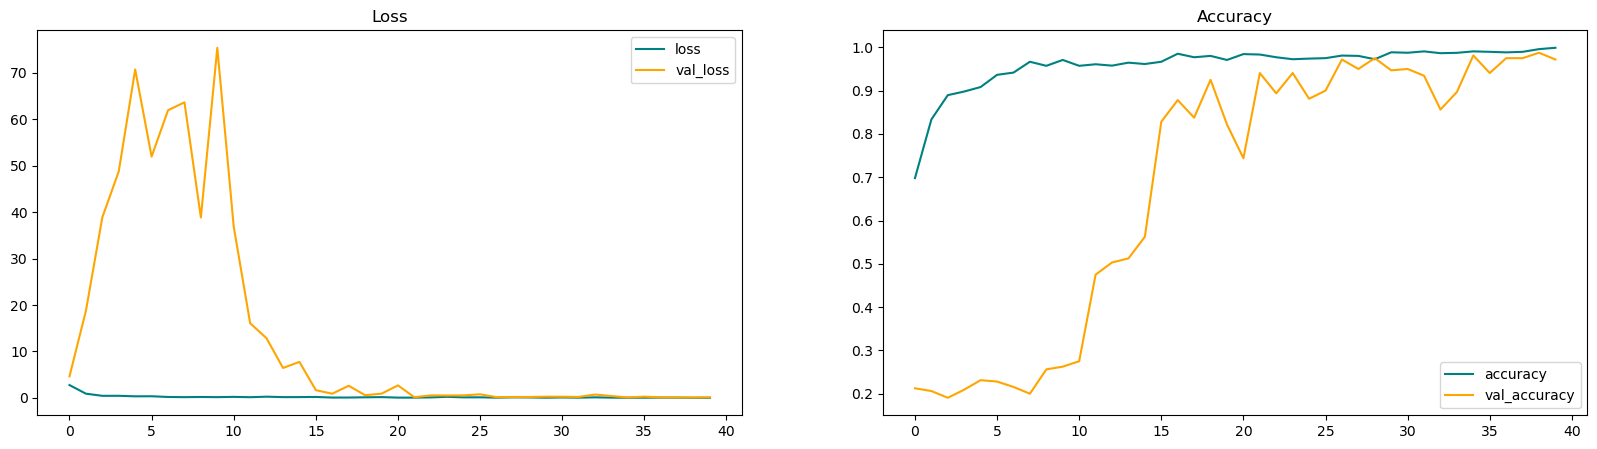

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,5))

ax[0].plot(hist.history['loss'], color = 'teal', label = 'loss')
ax[0].plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
ax[1].plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
ax[1].title.set_text('Accuracy')
ax[1].legend()

plt.show()

Save model

In [19]:
model.save('Face_Recognition_new.keras')
model.save("Face_Recognition_new.h5")
model.save("Face_Recognition_new.tf")

/opt/miniconda3/envs/face-recognition/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:tensorflow:Assets written to: Face_Recognition_new.tf/assets


Make Prediction

In [20]:
from keras.preprocessing import image

In [ ]:
face_recognition = load_model('Face_Recognition_new.keras')

with open("ResultsMap.pkl", 'rb') as file:
  result_map = pickle.load(file)

test_image = cv2.imread('Phuc2.jpg')

test_image = cv2.resize(test_image, (120,120))
 
test_image = np.expand_dims(test_image,axis=0)
 
result = face_recognition.predict(test_image,verbose=0) 
 
print('####'*10)
print(result)
print('Prediction is: ', result_map[np.argmax(result)])

Real time prediction

In [ ]:
def performFaceRecognition(vid) :
  facetracker = load_model('Quoc.h5')
  face_recognition = load_model('BatchNormalization.keras')
  
  with open("ResultsMap.pkl", 'rb') as file:
   result_map = pickle.load(file)
  
  
  while True :
    result, frame = vid.read()
    if result is False:
      break
    frame = frame[50 : 500, 50 : 500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255, 0))
    print(yhat)
    sample_coords = yhat[1][0]
  
    if yhat[0] > 0.5 :
      # Control the main rectangle
      cv2.rectangle(
        frame,
        tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
        (255,0,0),
        2 
      )
      
      resize = cv2.resize(
        frame[
          np.multiply(sample_coords[1], 450).astype(int) : np.multiply(sample_coords[3], 450).astype(int),
          np.multiply(sample_coords[0], 450).astype(int) : np.multiply(sample_coords[2], 450).astype(int)
        ],  
        (120,120)
      )
      
      name = face_recognition.predict(np.expand_dims(resize/255, 0), verbose=0)

      # Control the text rendered
      cv2.putText(
        frame, 
        result_map[np.argmax(name)],
        tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),[0, -5])),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255,255,255),
        2,
        cv2.LINE_AA
      )
      
    cv2.imshow("My Face Detection Project", frame) 
    if cv2.waitKey(1) & 0xFF == ord("q"):
      break
    
  vid.release()
  cv2.destroyAllWindows()
  
def accessCamera(IP_Stream) :
  return cv2.VideoCapture(IP_Stream)

# url = 'http://192.168.1.105'
video_stream = accessCamera(0)
performFaceRecognition(video_stream)